## An example of running CBP-SMF on the mRNA and miRNA data of breast cancer
1. Read original data provided by user.
2. Establish CBP_SMF_Solver and multi-run CBP-SMF algorithm.    
3. Display cost function and result matrices.
4. Predict unlabeled samples' label and extract each module's members.
5. *CBP_SMF_Solver can provide users **recommendation** if the rank of latent matrix and the parameters(beta,omega) are **not decided**.*

### 1. Read BRCA's mRNA and miRNA matrix, samples' subtype annotation, labeled samples' correlation matrix.
   * **Note** that the order of samples in above three data must be same, and put labeled samples in front of unlabeled samples.

In [1]:
%matplotlib inline
import CBP_SMF
import pandas as pd
import networkx as nx

In [2]:
X1_test_df = pd.read_csv('data\\final2_genematrix.csv', index_col='Keys')
X2_test_df = pd.read_csv('data\\final_miRNAmatrix_hsa.csv', index_col='sample')
corr_test_df = pd.read_csv('data\\final_corrmatrix.csv', index_col='Unnamed: 0')

In [3]:
X1_test = X1_test_df.as_matrix()
X2_test = X2_test_df.as_matrix()
corr_test = corr_test_df.as_matrix()

X1_feature = list(X1_test_df.index)
X2_feature = list(X2_test_df.index)

In [4]:
annotation = pd.read_csv('data\\final_annotation.csv').set_index('Unnamed: 0')
subtype = annotation.pop("subtype")
subtype_color = {'Luminal A': 'r', 'Luminal B': 'b',
                 'Basal like': 'g', 'HER2 enriched': 'y', 'Normal like': 'k'}
col_color = subtype.map(subtype_color)

background_network=open('data\\backgroud_network.txt', 'rb')
G=nx.nx.DiGraph()
for line in background_network.readlines():
        G.add_edge(line.split()[0],line.split()[1])

In [5]:
X1_test = CBP_SMF.normalization(X1_test)
X2_test = CBP_SMF.normalization(X2_test)
X_input = [X1_test, X2_test]

In [6]:
labeled_count = CBP_SMF.subtype_information(subtype)
labeled_sample_list = X1_test_df.columns[0:labeled_count[-1]]
unlabeled_sample_list = X1_test_df.columns[labeled_count[-1]:]

### 2. Establish CBP_SMF_Solver and pass parameters.

In [7]:
CBP_SMF_obj = CBP_SMF.CBP_SMF_Solver(X_input=X_input, rank=4, n_iter=50, beta=10, omega=100000,
                                     corr_matrix=corr_test, labeled_count=labeled_count, subgroup=subtype,
                                     multi_runtimes=10, consensus_runtimes=10,
                                     labeled_sample_list=labeled_sample_list, unlabeled_sample_list=unlabeled_sample_list,
                                     z_threshold=1.2,background_network=G, col_color=col_color)

#### Arguments of CBP_SMF_Solver  
**X_input** (List): List of input Xi matrices.  
**rank** (int): the rank of latent matrix. 
**n_iter** (int): Number of iteration in each run.  
**beta** (int / float): Representation of the importance of semi-supervised part.  
**omega** (int / float):   Representation of the importance of weight part.  
**corr_matrix** (Matrix): Correlation matrix of labeled samples.   
**labeled_count** (List): Count of each subtype's samples.   
**subgroup** (Series): Subtype of each labeled sample.  
**multi_runtimes** (int): Times of run NMF to get best solution.  
**consensus_runtimes** (int): Times of run NMF to implement consensus clustering.  
**labeled_sample_list** (List): Labeled samples' name.  
**unlabeled_sample_list** (List):  Unlabeled samples' name.  
**z_threshold** (float): Threshold to get each module's members.  
**col_color** (Dict): Mapping of subtype to colors when displaying results.  

In [10]:
cost_min, U_min, W_min, V_min, PI_min, purity_list, ARI_list, NMI_list = CBP_SMF_obj.multirun()

runtimes:[ 1 /10]
optimize done
runtimes:[ 2 /10]
runtimes:[ 3 /10]
runtimes:[ 4 /10]
Error: incorrect cluster number!
runtimes:[ 5 /10]
optimize done
runtimes:[ 6 /10]
runtimes:[ 7 /10]
runtimes:[ 8 /10]
runtimes:[ 9 /10]
runtimes:[ 10 /10]


### 3. Display results through clustering metrics and several plots.

- **Metrics**
  - Purity.
  - ARI.
  - NMI.
- **Plots**
  - Cost of CBP-SMF through optimization.
  - Clustermap of Vl (labeled parts of V) matrix .
  - Each module's line plot and boxplot in Vl  matrix.

Purity:
0.988826815642
ARI:
0.96539250379
NMI:
0.962341262468


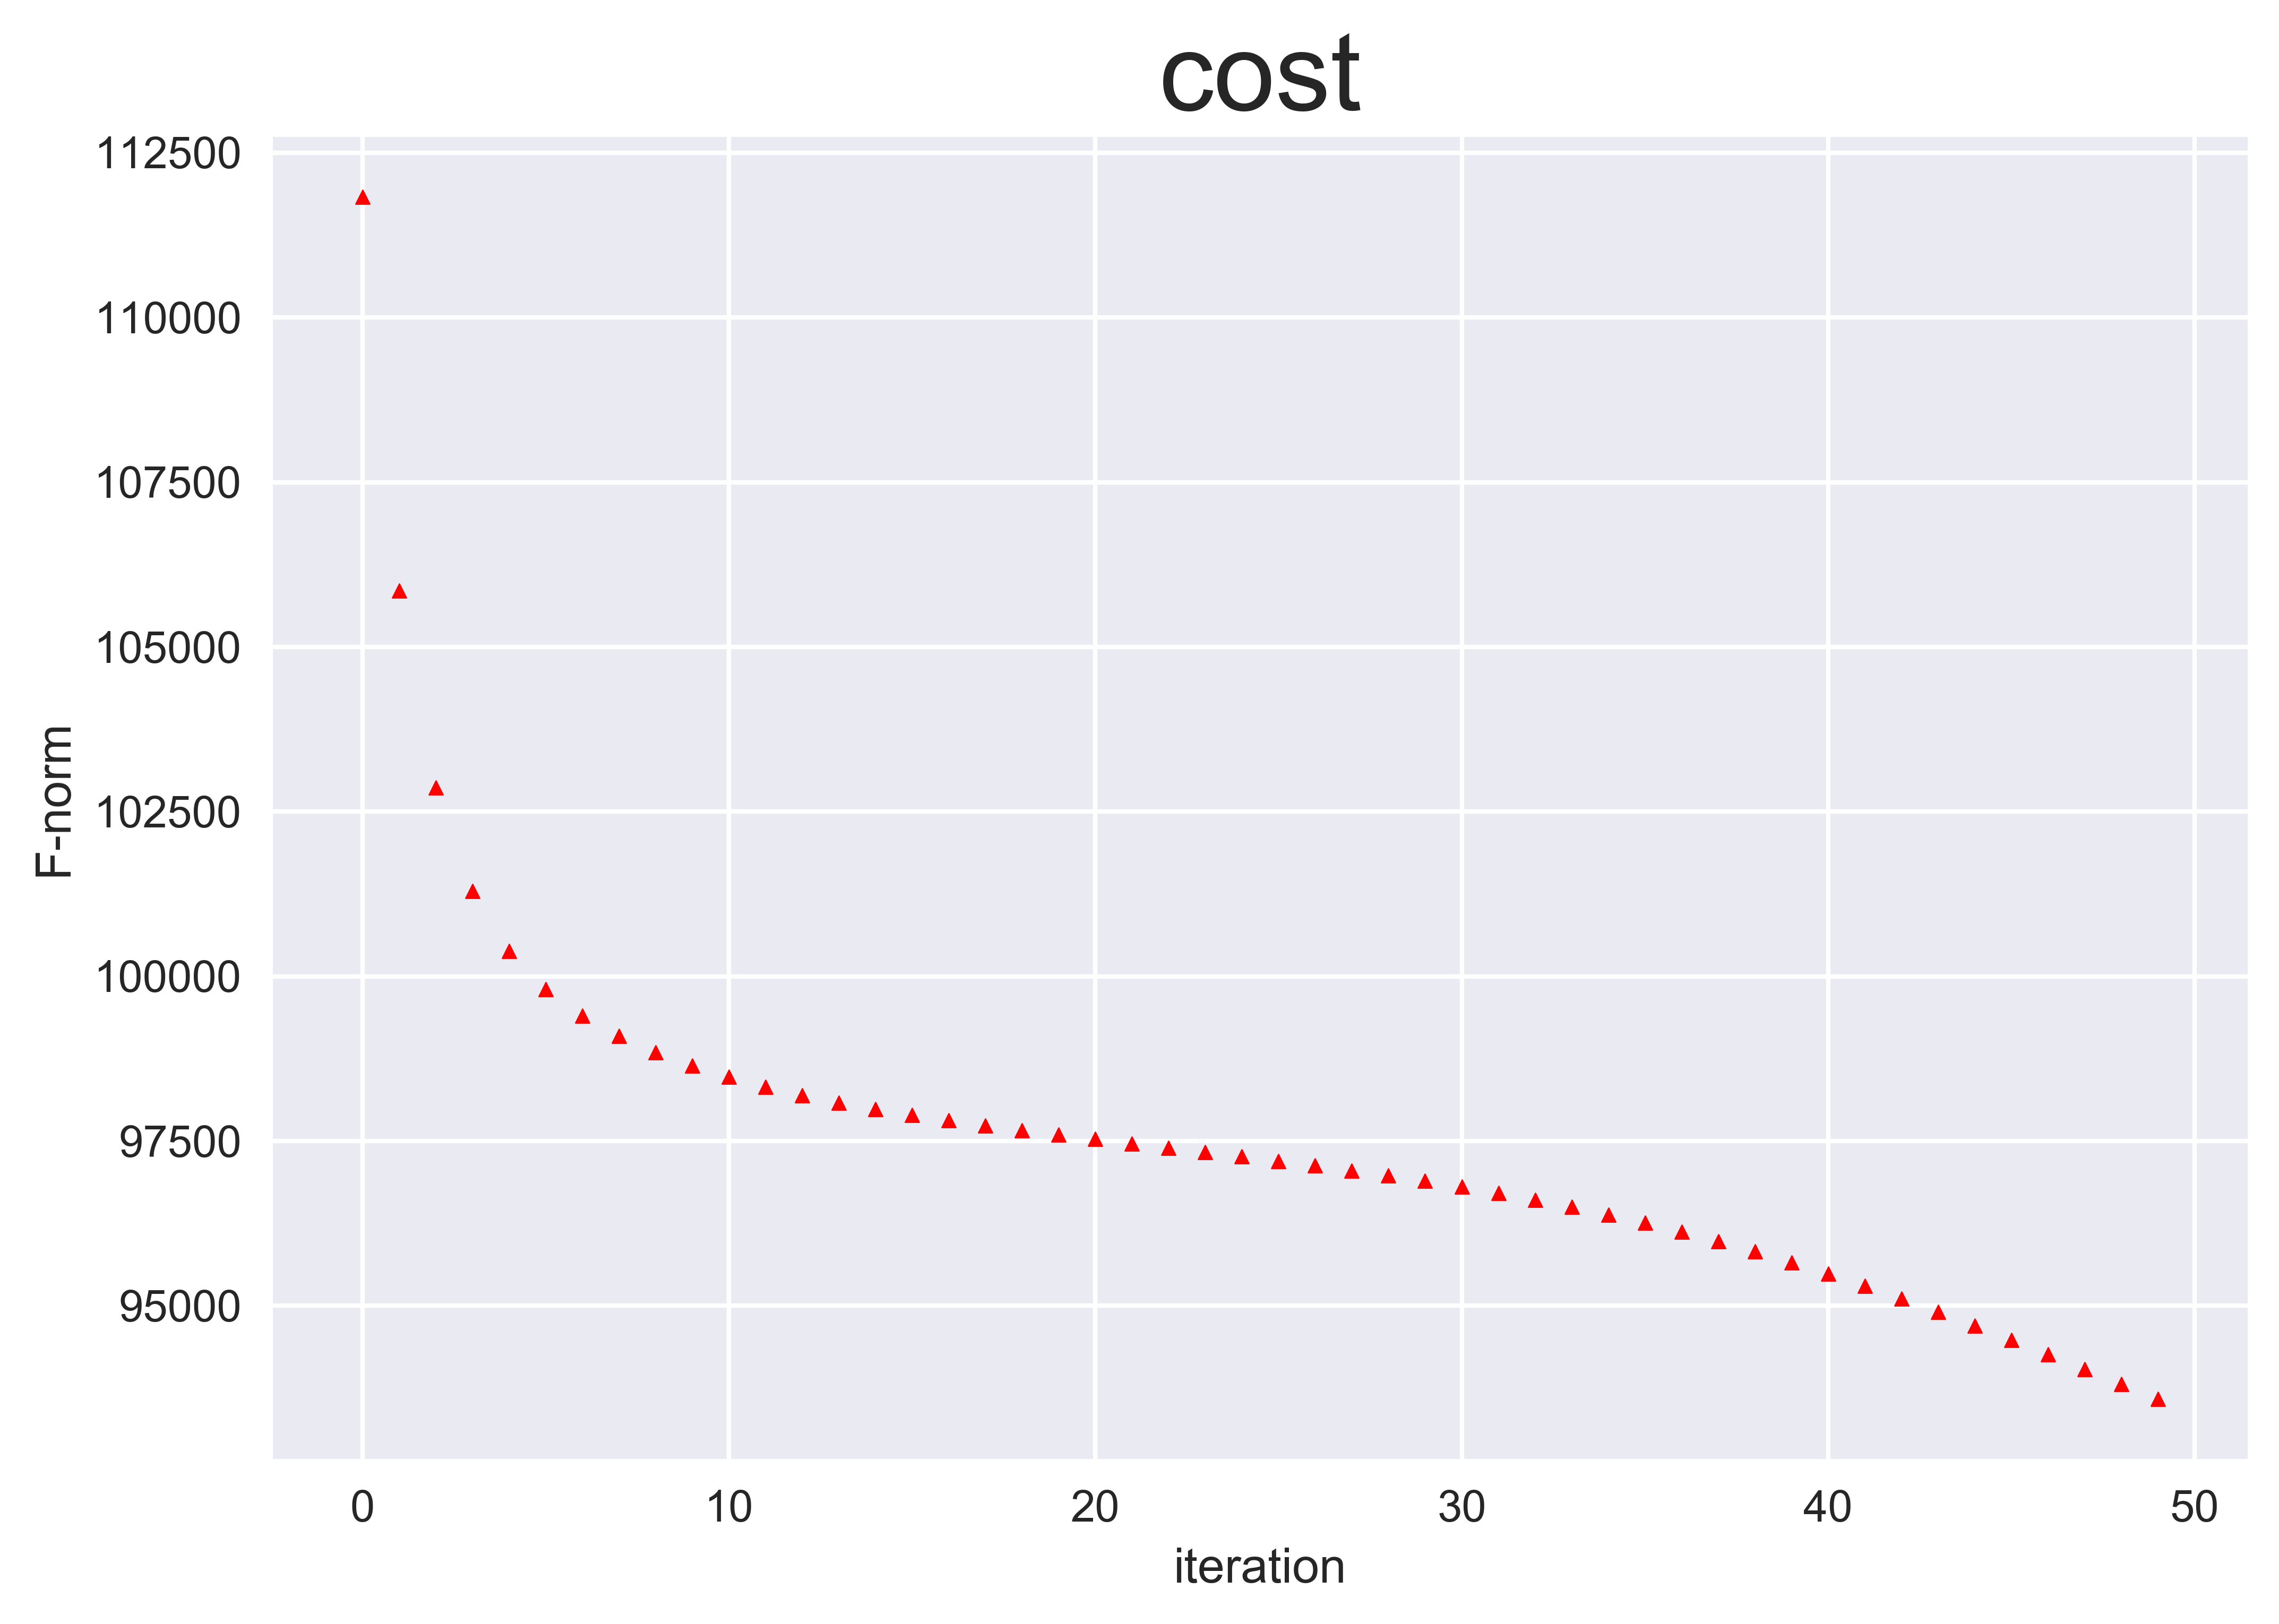

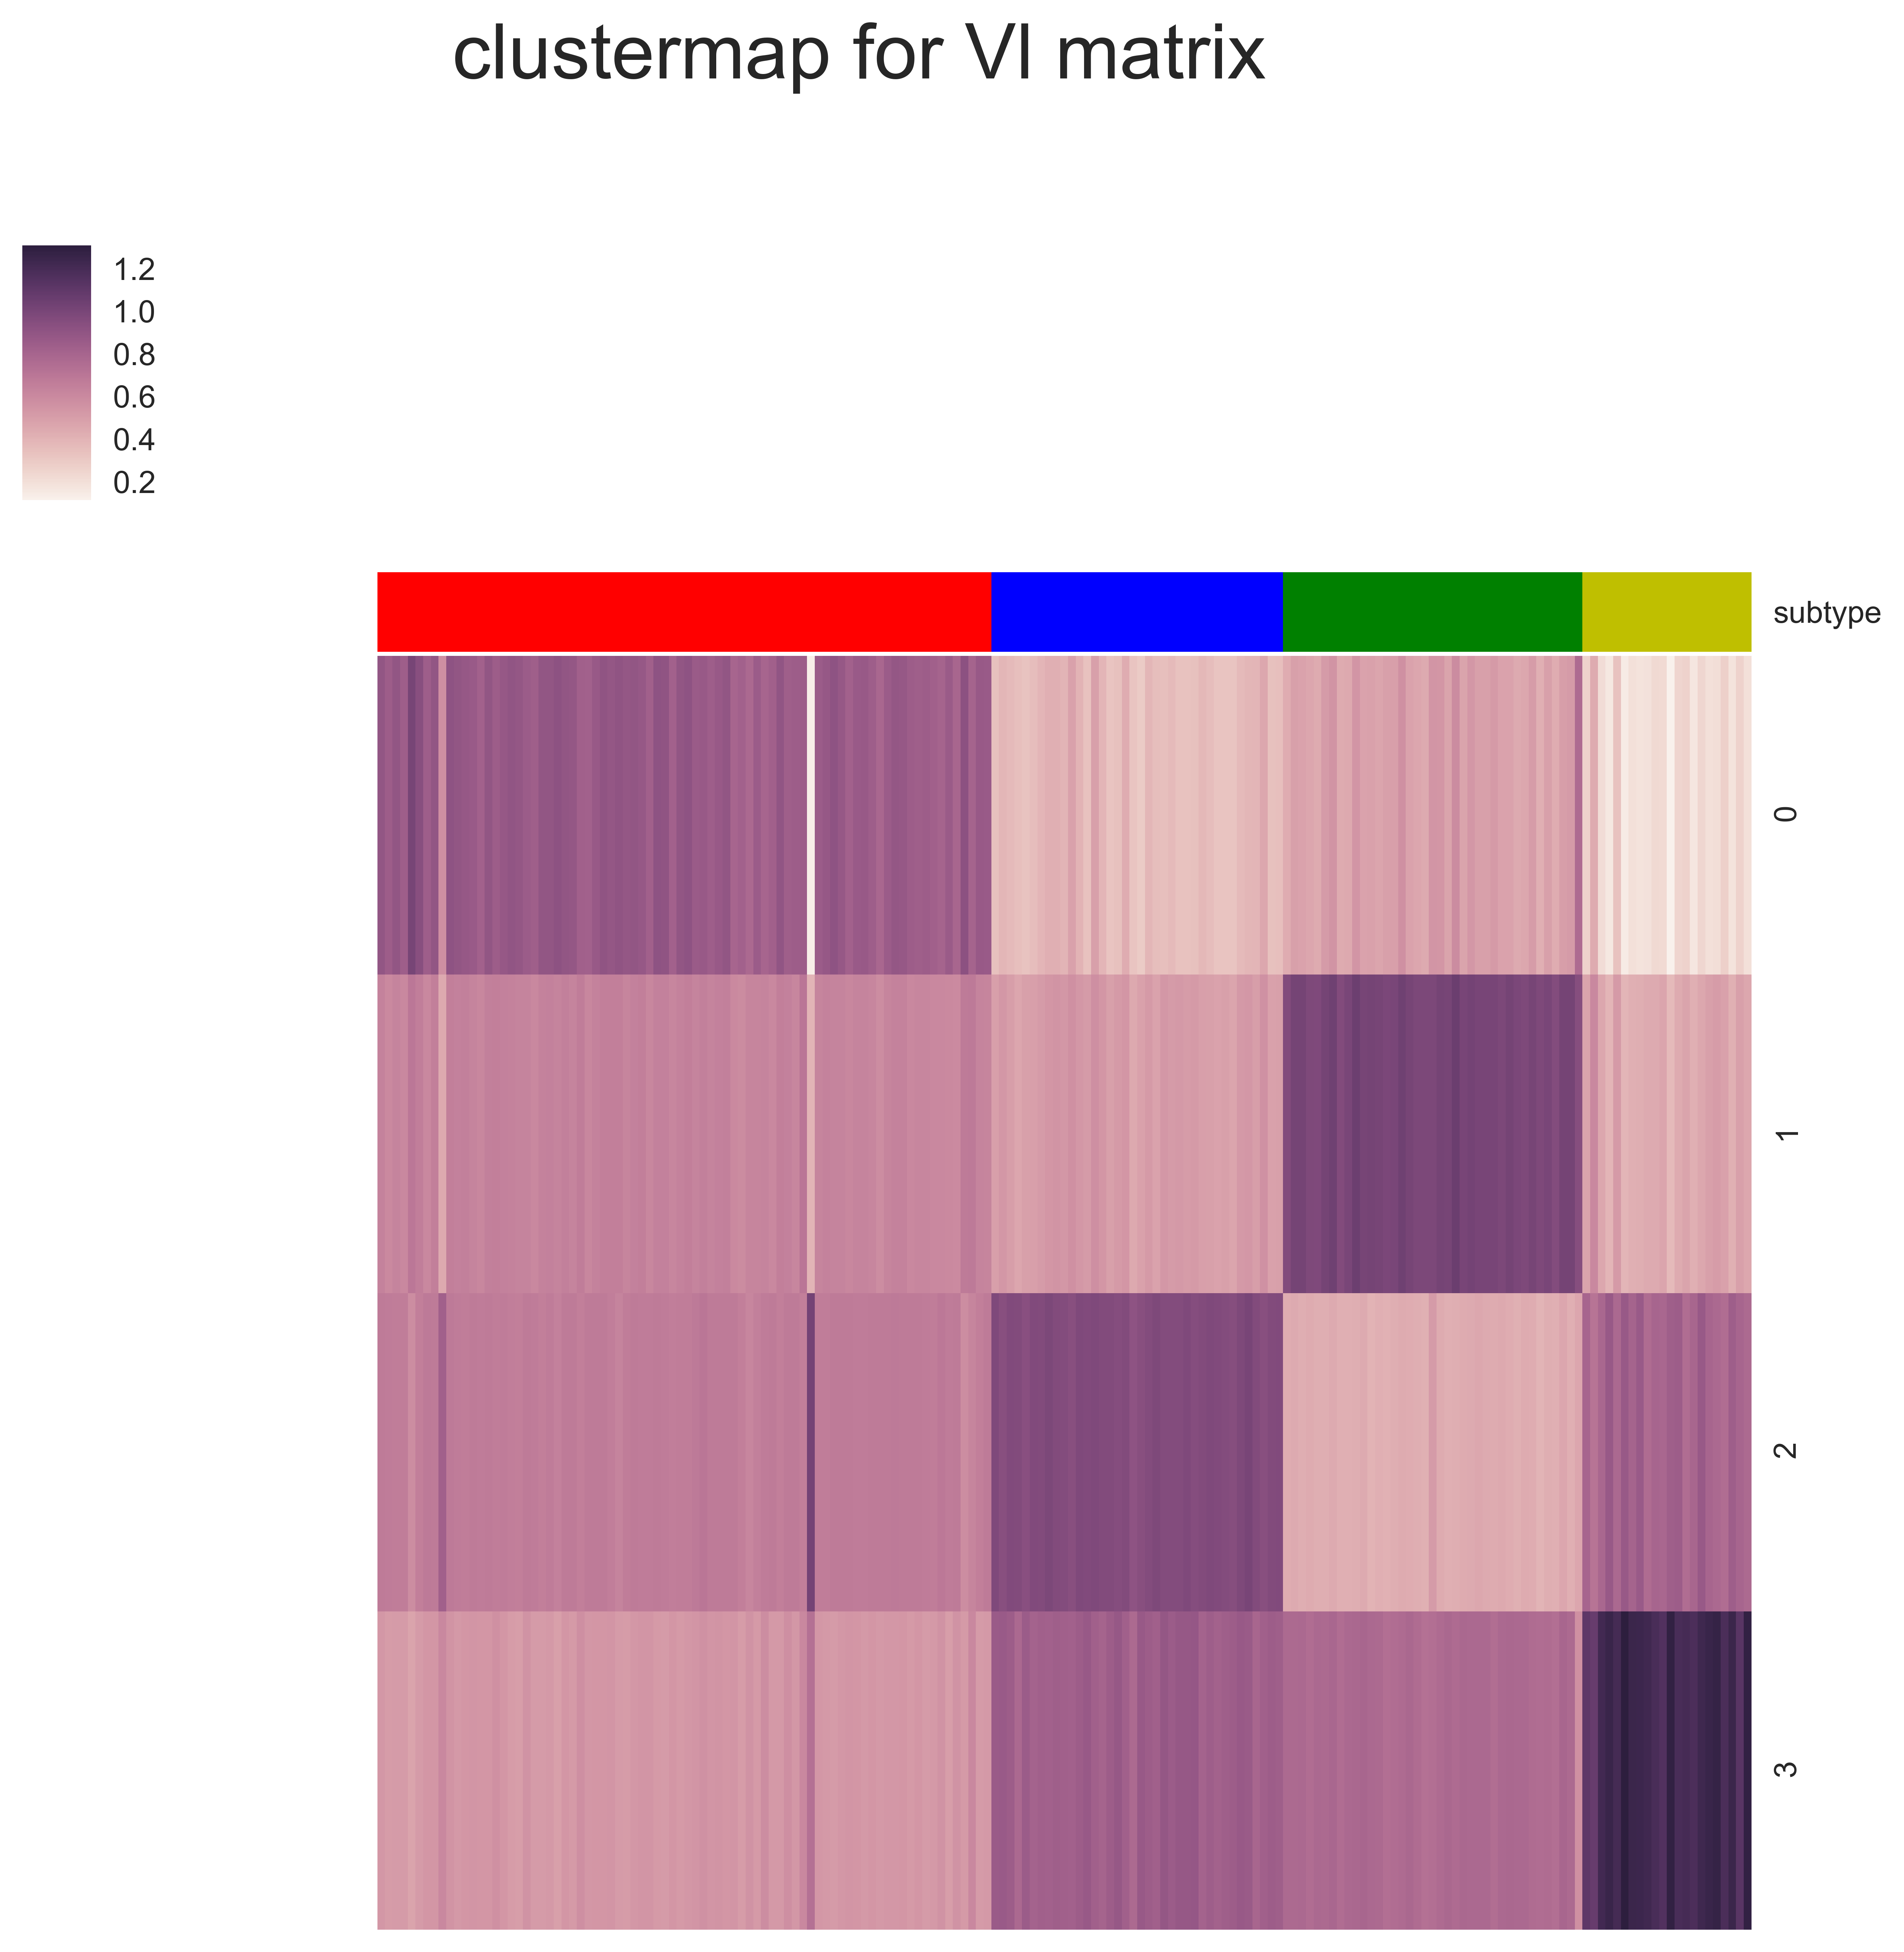

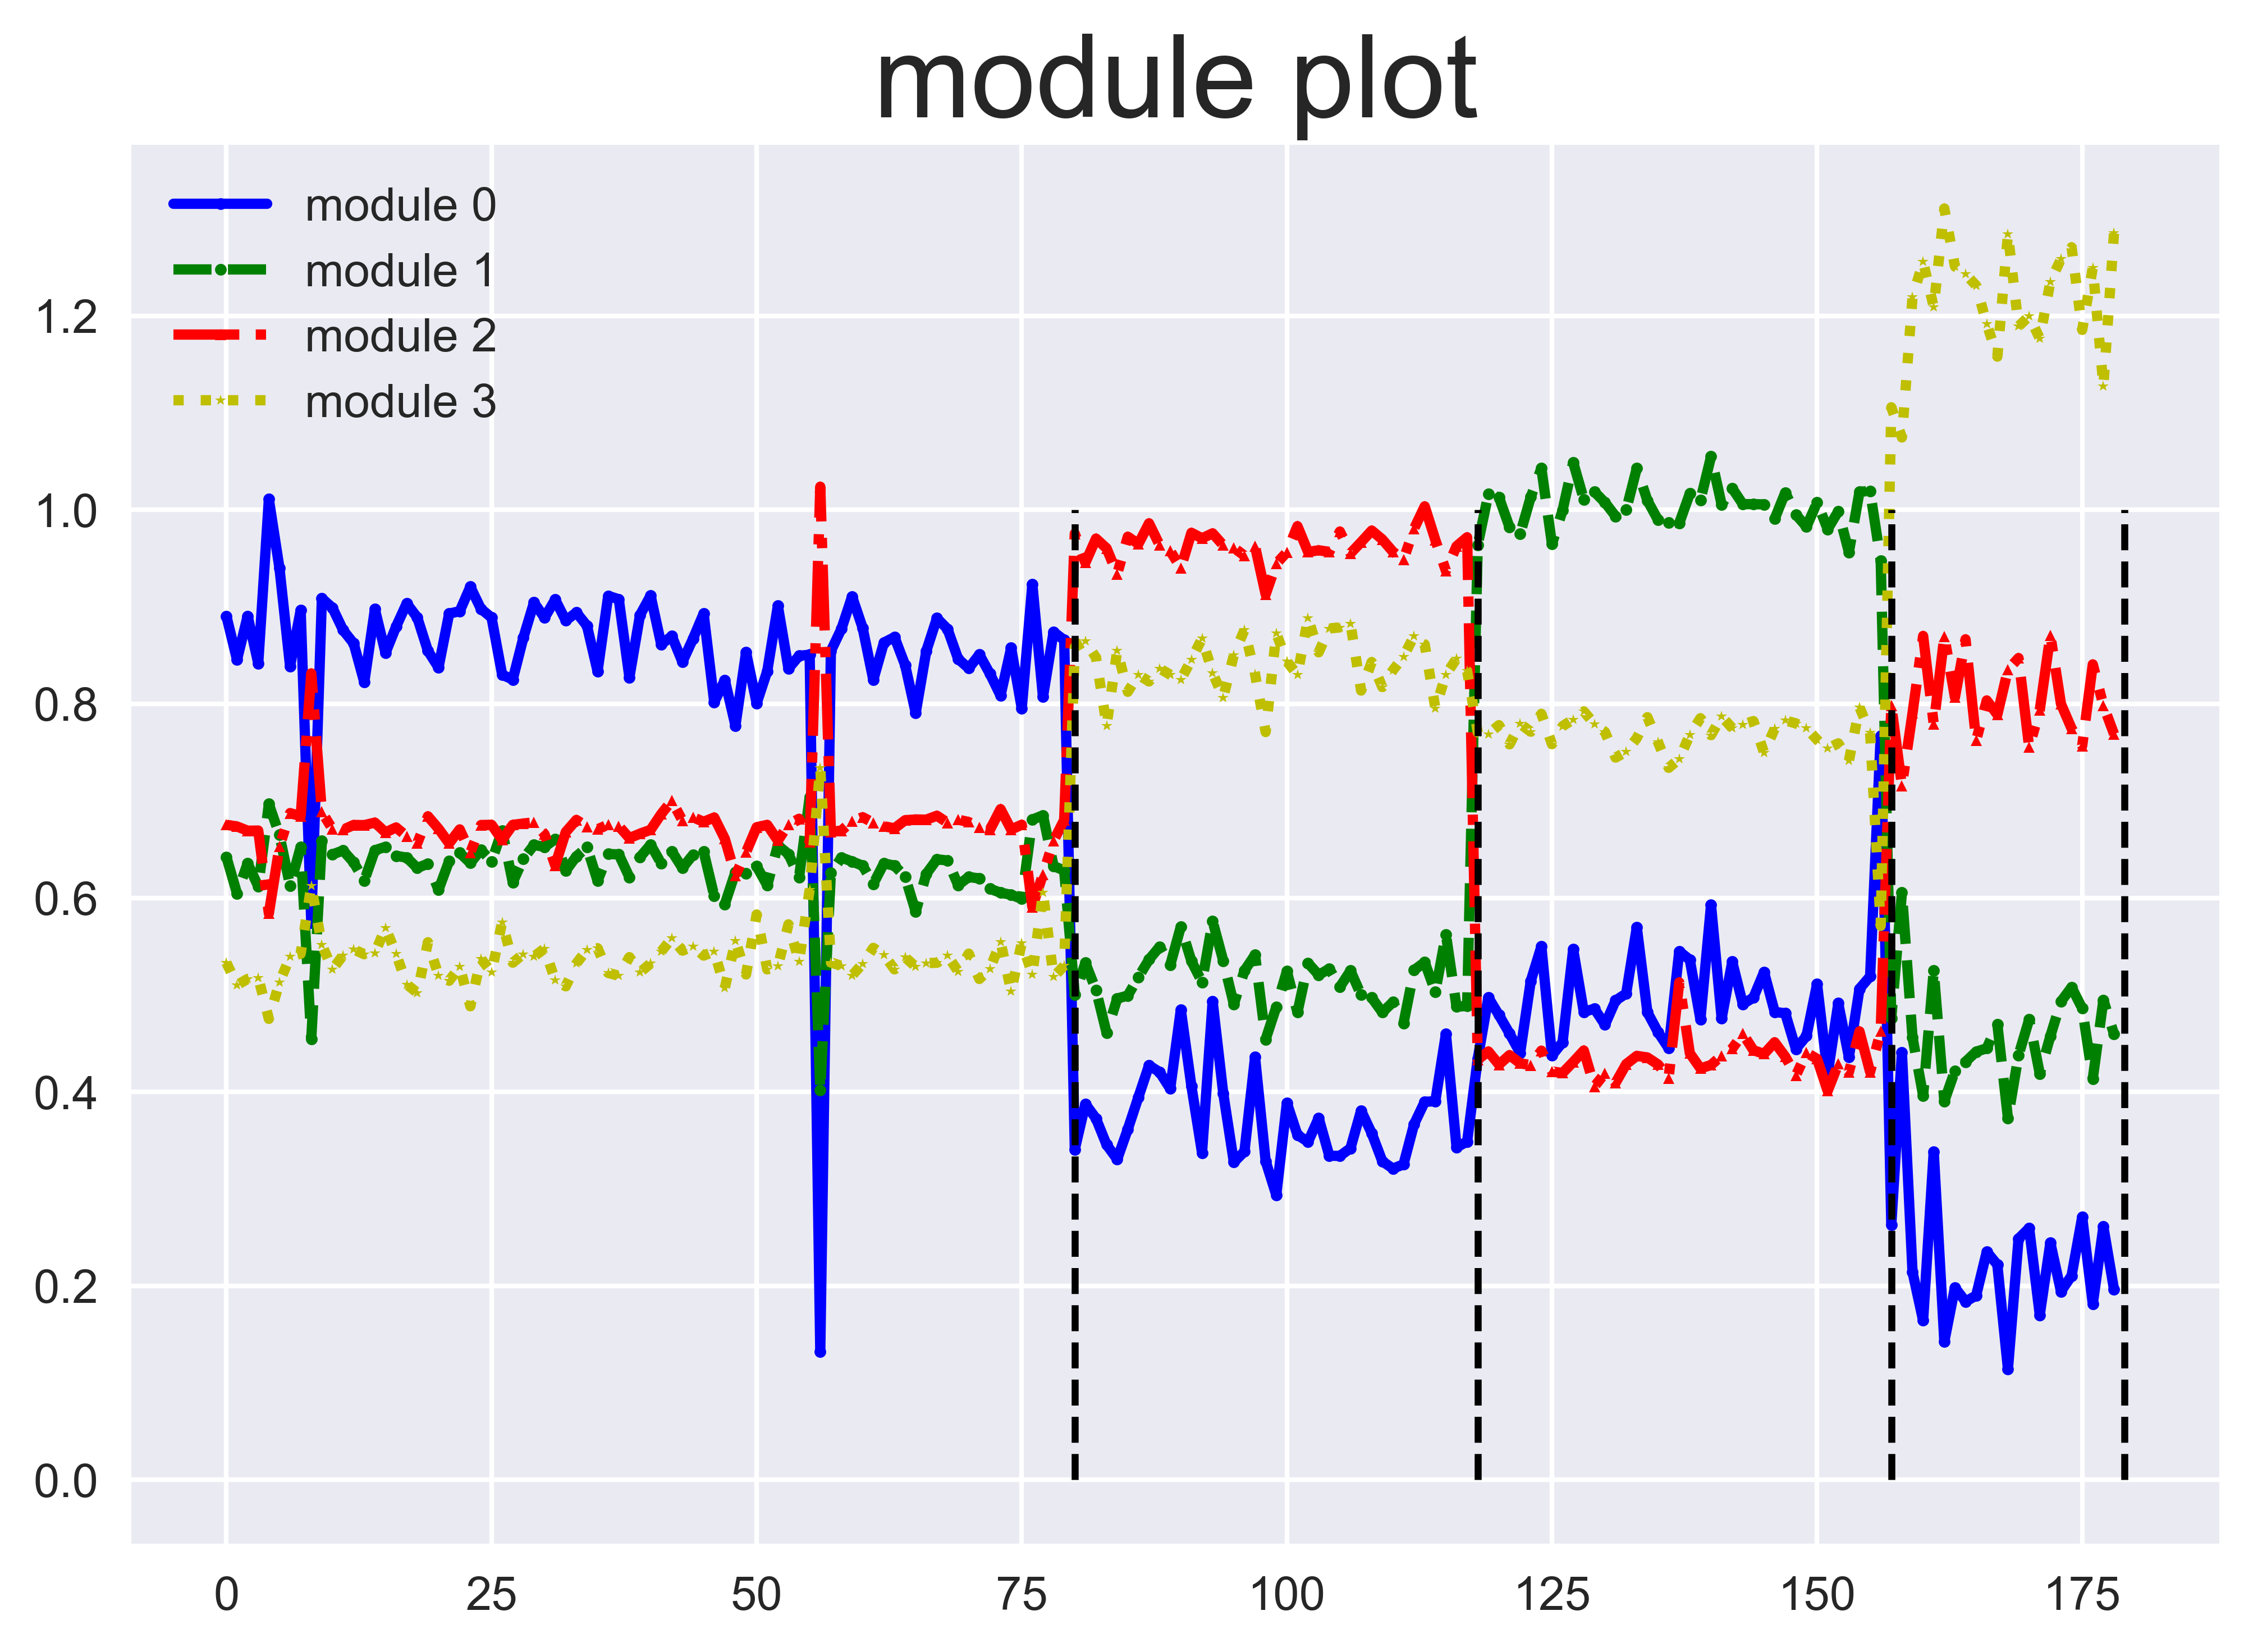

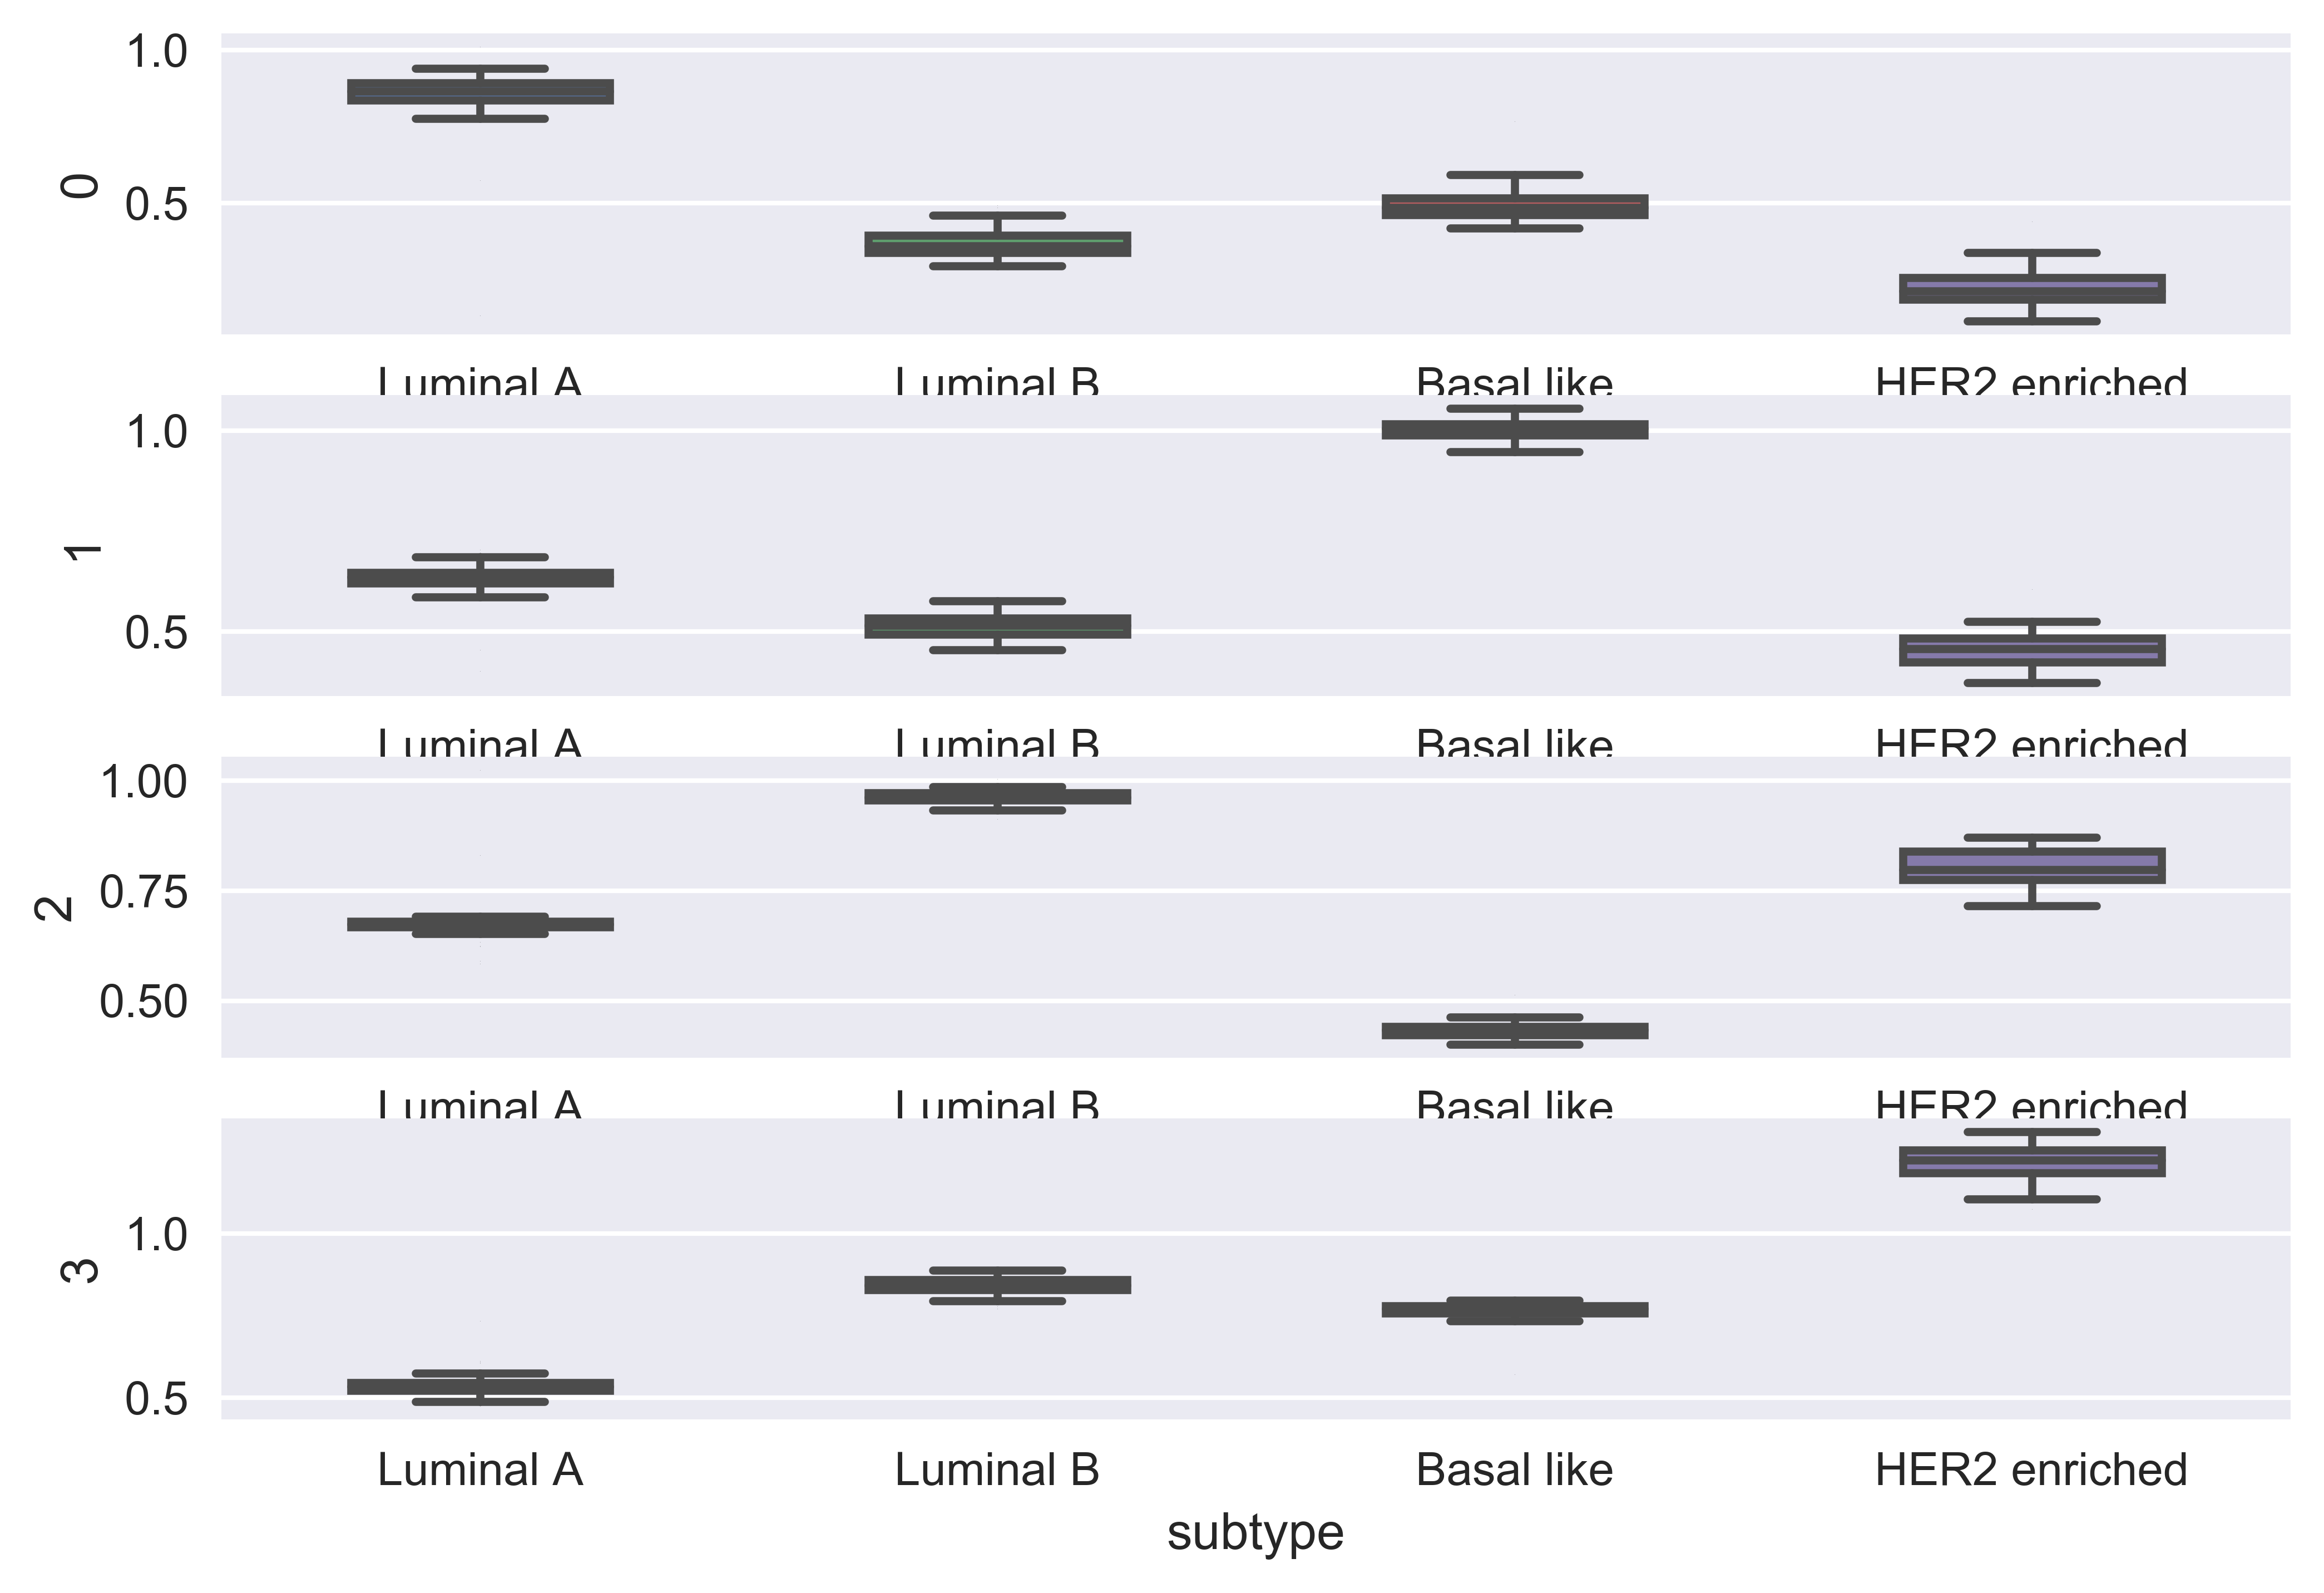

In [11]:
CBP_SMF_obj.display_analysis(V_min, cost_min)

### 4. Predict label of unlabeled samples and extract each subtype's corresponding heterogeneous module.

In [16]:
prediction_result = CBP_SMF_obj.predict_subtype(V_min)

In [17]:
CBP_SMF_obj.writeSampleGroup(prediction_result)

In [18]:
CBP_SMF_obj.subtype_module_correspond(V_min)
module_from_X1 = CBP_SMF_obj.getmodulegene(X1_feature, U_min[0])
module_from_X2 = CBP_SMF_obj.getmodulegene(X2_feature, U_min[1])

Corresponding relationship between module and subtype are:
CBPs_module:1 corresponds to subtype:Luminal A
CBPs_module:2 corresponds to subtype:Basal like
CBPs_module:3 corresponds to subtype:Luminal B
CBPs_module:4 corresponds to subtype:HER2 enriched


In [19]:
CBP_edges=CBP_SMF_obj.getCBPedges([module_from_X1,module_from_X2])

In [20]:
CBP_SMF_obj.writeCBP(CBP_edges)

### 5. Provide users **recommendation** of rank k,beta and omega.  
* CBP_SMF performs a consensus clustering to determine k through calculating cophenetic coefficient.
* CBP_SMF recommend beta and omega through relative size of norm.

In [15]:
CBP_SMF_obj.parameter_recommendation()

CBP_SMF recommendation of beta : 9.2240 (±50%)
CBP_SMF recommendation of gamma: 100000 (±50%)


##### We recommend users to select rank of highest cophenetic coefficient, in our example(plot below), rank=4 or 5 is the best solution.

running rank: 2
running rank: 3
running rank: 4
running rank: 5
running rank: 6
running rank: 7


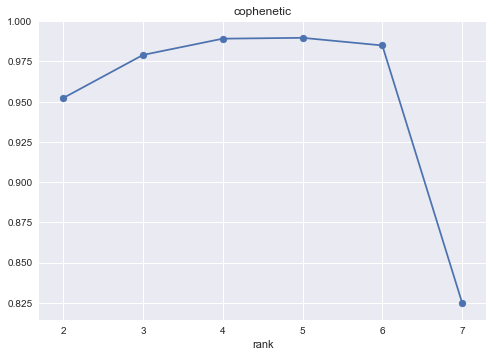

In [16]:
cophenet = CBP_SMF_obj.cophenetic(rank_start=2, rank_end=7)